In [ ]:
import pandas as pd

PATH = "7282_1_dedupe.csv"
OUT  = "7282_1_dedupe_cleaned.csv"

df_raw = pd.read_csv(PATH)          # read
drop_cols = ['reviews.id','reviews.doRecommend','reviews.userCity','reviews.userProvince']

# (optional) guard against missing columns
present = [c for c in drop_cols if c in df_raw.columns]
missing = [c for c in drop_cols if c not in df_raw.columns]
if missing: print("Not found, skipping:", missing)

df_clean = df_raw.drop(columns=present)   # make cleaned copy
df_clean.to_csv(OUT, index=False)


In [4]:
df = pd.read_csv("7282_1_dedupe_cleaned.csv")
summary = pd.DataFrame({
    'dtype': df.dtypes.astype(str),
    'n_unique': df.nunique(dropna=True)
}).sort_index()
summary

,dtype,n_unique
address,object,999
categories,object,396
city,object,761
country,object,1
latitude,float64,982
longitude,float64,983
name,object,879
postalCode,object,911
province,object,287
reviews.date,object,3009


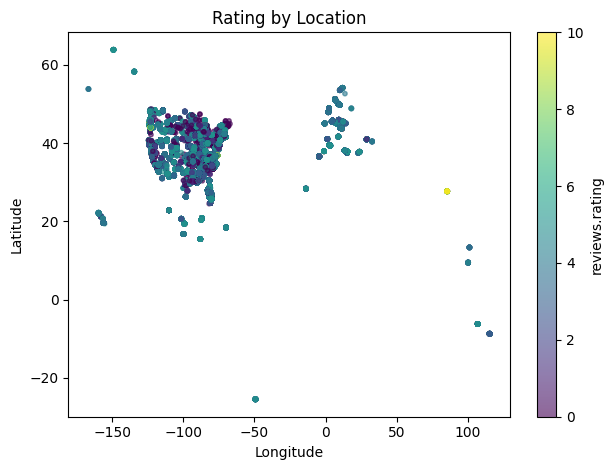

In [ ]:
# MARK : --- NuMERIC vs NUMERIC PLOT ---

import pandas as pd
import matplotlib.pyplot as plt

# df already loaded from "7282_1_dedupe_cleaned.csv"
tmp = df[['longitude','latitude','reviews.rating']].copy()
tmp = tmp.apply(pd.to_numeric, errors='coerce').dropna()
tmp = tmp[tmp['longitude'].between(-180,180) & tmp['latitude'].between(-90,90)]

sc = plt.scatter(tmp['longitude'], tmp['latitude'],
                 c=tmp['reviews.rating'], s=10, alpha=0.6)
plt.xlabel('Longitude'); plt.ylabel('Latitude'); plt.title('Rating by Location')
plt.colorbar(sc, label='reviews.rating')
plt.tight_layout(); plt.show()


C:\Users\vanoh\AppData\Local\Temp\ipykernel_19936\3929685287.py:20: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=order, showfliers=False)
C:\Users\vanoh\AppData\Local\Temp\ipykernel_19936\3929685287.py:24: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


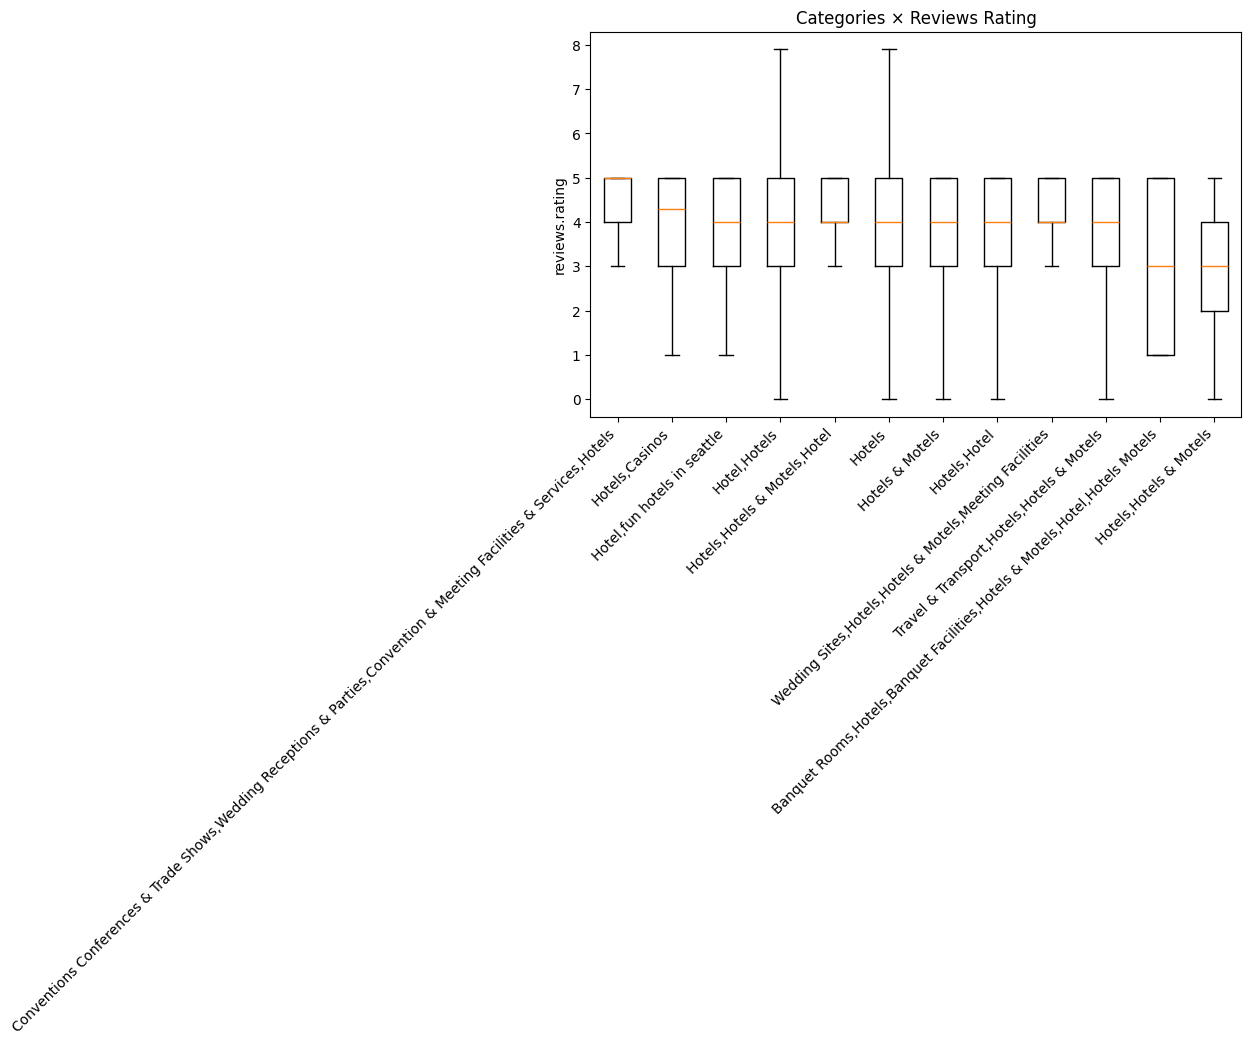

C:\Users\vanoh\AppData\Local\Temp\ipykernel_19936\3929685287.py:20: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=order, showfliers=False)


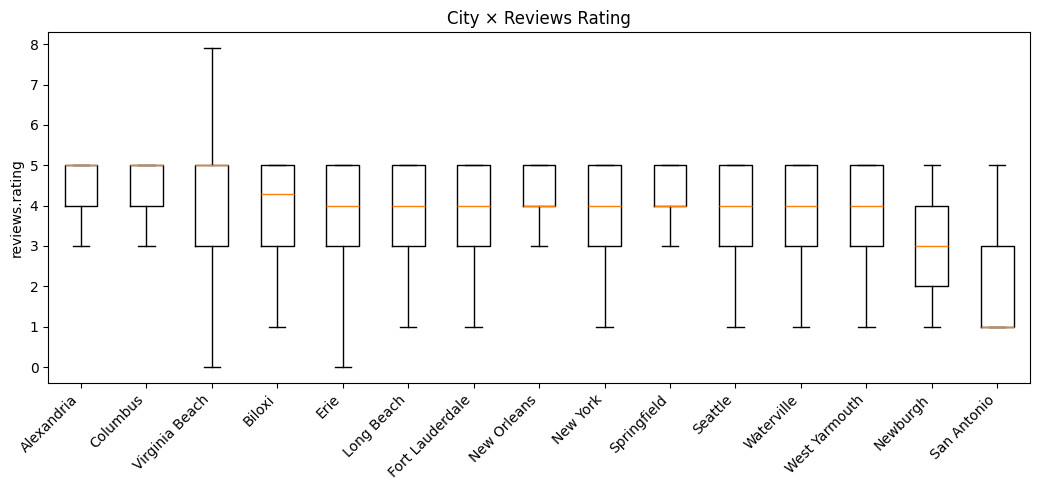

In [6]:
# MARK : --- CATEGORICAL vs NUMERIC PLOT ---

import pandas as pd
import matplotlib.pyplot as plt

def box_by_cat(df, cat_col, num_col, top_n=12, min_count=20, title=None):
    t = df[[cat_col, num_col]].copy()
    t[num_col] = pd.to_numeric(t[num_col], errors='coerce')
    t = t.dropna()


    freq = t[cat_col].value_counts()
    keep = freq[freq >= min_count].head(top_n).index
    t = t[t[cat_col].isin(keep)]

    order = t.groupby(cat_col)[num_col].median().sort_values(ascending=False).index

    data = [t.loc[t[cat_col] == c, num_col].values for c in order]
    plt.figure(figsize=(max(8, 0.7*len(order)), 5))
    plt.boxplot(data, labels=order, showfliers=False)
    plt.ylabel(num_col)
    plt.title(title or f"{cat_col} × {num_col}")
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

box_by_cat(df, 'categories', 'reviews.rating',
           top_n=12, min_count=20, title='Categories × Reviews Rating')

box_by_cat(df, 'city', 'reviews.rating',
           top_n=15, min_count=20, title='City × Reviews Rating')


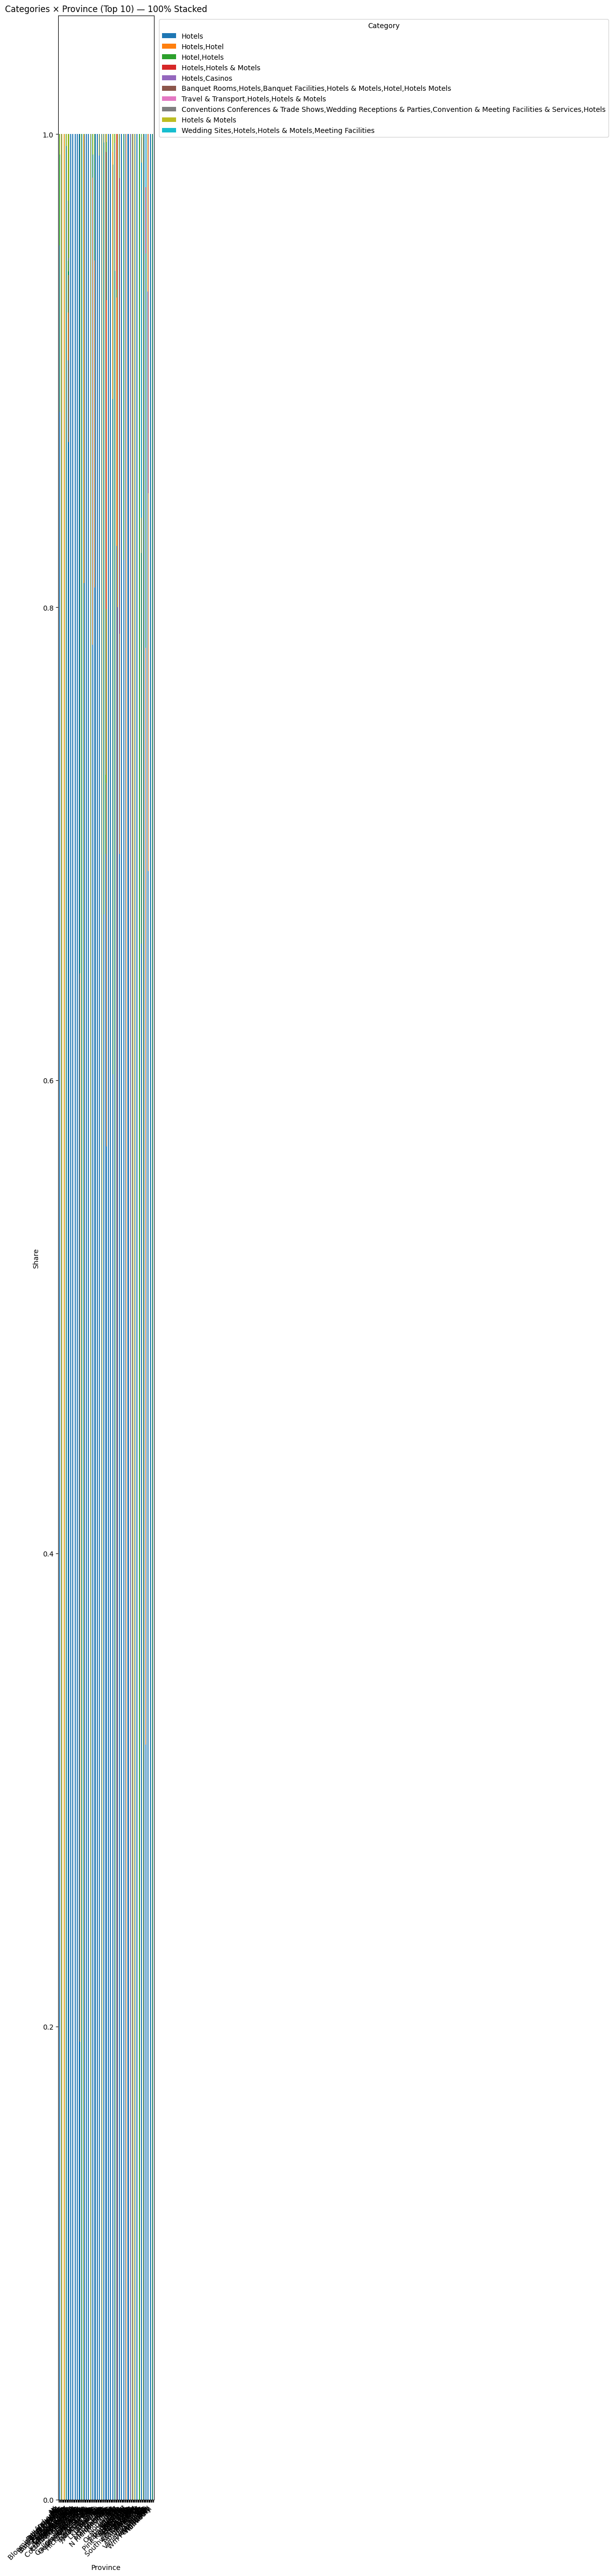

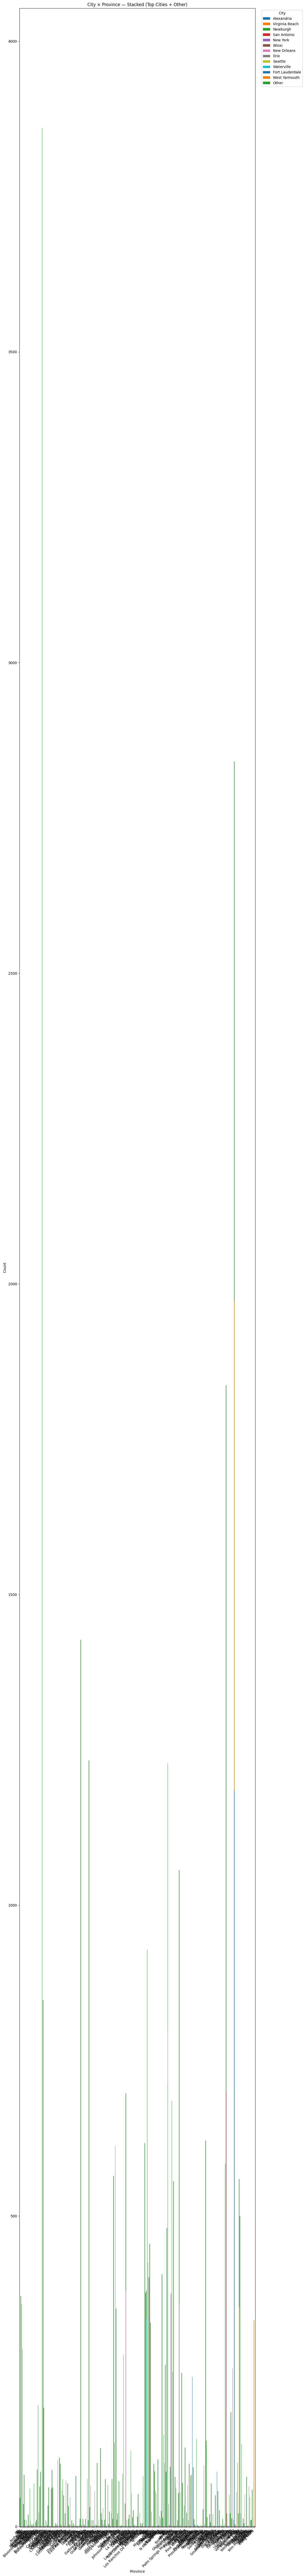

In [8]:
# MARK : --- CATEGORICAL vs CATEGORICAL PLOT ---

import pandas as pd
import matplotlib.pyplot as plt

# Top 10 categories overall
top_cats = df['categories'].astype(str).value_counts().head(10).index
sub = df[df['categories'].astype(str).isin(top_cats)]

# Crosstab and normalize to percentages per province
ct = pd.crosstab(sub['province'].astype(str), sub['categories'].astype(str))
ct = ct[top_cats]                                  # keep fixed order
ct_pct = ct.div(ct.sum(axis=1), axis=0).fillna(0)  # 0–1 proportions

ax = ct_pct.plot(kind='bar', stacked=True, figsize=(12, max(5, 0.35*len(ct_pct))))
ax.set_xlabel('Province'); ax.set_ylabel('Share'); ax.set_title('Categories × Province (Top 10) — 100% Stacked')
plt.xticks(rotation=45, ha='right'); plt.legend(title='Category', bbox_to_anchor=(1.02,1), loc='upper left')
plt.tight_layout(); plt.show()



TOP_N_CITIES = 12
top_cities = df['city'].astype(str).value_counts().head(TOP_N_CITIES).index

ct = pd.crosstab(df['province'].astype(str), df['city'].astype(str))
other = ct.drop(columns=top_cities, errors='ignore').sum(axis=1)
ct = ct.reindex(columns=top_cities, fill_value=0)
ct['Other'] = other

# Use counts (stacked) or percentage (100% stacked). Pick ONE:
# counts:
ax = ct.plot(kind='bar', stacked=True, figsize=(12, max(5, 0.35*len(ct))))
ax.set_ylabel('Count'); ax.set_title('City × Province — Stacked (Top Cities + Other)')

# percentages (uncomment to use instead):
# ct_pct = ct.div(ct.sum(axis=1), axis=0).fillna(0)
# ax = ct_pct.plot(kind='bar', stacked=True, figsize=(12, max(5, 0.35*len(ct_pct))))
# ax.set_ylabel('Share'); ax.set_title('City × Province — 100% Stacked (Top Cities + Other)')

ax.set_xlabel('Province')
plt.xticks(rotation=45, ha='right'); plt.legend(title='City', bbox_to_anchor=(1.02,1), loc='upper left')
plt.tight_layout(); plt.show()